# ADEME

## Spark setup

In [2]:
import pyspark
from pyspark.sql import SparkSession

conf = (
    pyspark.SparkConf()
    .setMaster("local[*]")
    .setAll(
        [
            ("spark.executor.memory", "1g"),  # find
            ("spark.driver.memory", "1g"),  # your
            ("spark.driver.maxResultSize", "1g"),  # setup
        ]
    )
)
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext
spark

In [3]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

/home/ariasnic/.local/share/virtualenvs/nf26-project-ariasnic-9ROSvyQx/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
<ipython-input-3-335904d720c3>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [23]:
df = spark.read.csv("/home/ariasnic/data/raw2", header=True)

In [24]:
df.createOrReplaceTempView("ademe_33")
df.columns

['id',
 'numero_dpe',
 'usr_diagnostiqueur_id',
 'usr_logiciel_id',
 'tr001_modele_dpe_id',
 'nom_methode_dpe',
 'version_methode_dpe',
 'nom_methode_etude_thermique',
 'version_methode_etude_thermique',
 'date_visite_diagnostiqueur',
 'date_etablissement_dpe',
 'date_arrete_tarifs_energies',
 'commentaires_ameliorations_recommandations',
 'explication_personnalisee',
 'consommation_energie',
 'classe_consommation_energie',
 'estimation_ges',
 'classe_estimation_ges',
 'tr002_type_batiment_id',
 'secteur_activite',
 'tr012_categorie_erp_id',
 'tr013_type_erp_id',
 'annee_construction',
 'surface_habitable',
 'surface_thermique_lot',
 'tv016_departement_id',
 'commune',
 'arrondissement',
 'type_voie',
 'nom_rue',
 'numero_rue',
 'batiment',
 'escalier',
 'etage',
 'porte',
 'code_postal',
 'code_insee_commune',
 'code_insee_commune_actualise',
 'numero_lot',
 'quote_part',
 'nom_centre_commercial',
 'surface_commerciale_contractuelle',
 'portee_dpe_batiment',
 'partie_batiment',
 'shon

In [5]:
corr1 = spark.sql("""
    SELECT
        corr(consommation_energie,estimation_ges)
    FROM ademe_33
""")
corr1.persist()
corr1.show()

+--------------------------------------------------------------------------+
|corr(CAST(consommation_energie AS DOUBLE), CAST(estimation_ges AS DOUBLE))|
+--------------------------------------------------------------------------+
|                                                        0.9154768940793269|
+--------------------------------------------------------------------------+



In [6]:
results = spark.sql("""
    SELECT
        classe_consommation_energie, consommation_energie, annee_construction, numero_dpe, surface_habitable, estimation_ges, surface_thermique_lot,
        nombre_niveaux, surface_baies_orientees_nord, surface_baies_orientees_est_ouest,
        surface_baies_orientees_sud, surface_planchers_hauts_deperditifs, surface_planchers_bas_deperditifs, surface_parois_verticales_opaques_deperditives
    FROM ademe_33
    ORDER BY classe_consommation_energie
""")
results.persist()

DataFrame[classe_consommation_energie: string, consommation_energie: string, annee_construction: string, numero_dpe: string, surface_habitable: string, estimation_ges: string, surface_thermique_lot: string, nombre_niveaux: string, surface_baies_orientees_nord: string, surface_baies_orientees_est_ouest: string, surface_baies_orientees_sud: string, surface_planchers_hauts_deperditifs: string, surface_planchers_bas_deperditifs: string, surface_parois_verticales_opaques_deperditives: string]

In [7]:
results.columns

['classe_consommation_energie',
 'consommation_energie',
 'annee_construction',
 'numero_dpe',
 'surface_habitable',
 'estimation_ges',
 'surface_thermique_lot',
 'nombre_niveaux',
 'surface_baies_orientees_nord',
 'surface_baies_orientees_est_ouest',
 'surface_baies_orientees_sud',
 'surface_planchers_hauts_deperditifs',
 'surface_planchers_bas_deperditifs',
 'surface_parois_verticales_opaques_deperditives']

In [8]:
results_pd = results.toPandas()

In [9]:
results_pd.surface_habitable = pd.to_numeric(results_pd.surface_habitable)
results_pd.estimation_ges = pd.to_numeric(results_pd.estimation_ges)
results_pd.consommation_energie = pd.to_numeric(results_pd.consommation_energie)
results_pd.annee_construction = pd.to_numeric(results_pd.annee_construction)
results_pd.surface_thermique_lot = pd.to_numeric(results_pd.surface_thermique_lot)
results_pd.nombre_niveaux = pd.to_numeric(results_pd.nombre_niveaux)
results_pd.surface_baies_orientees_nord = pd.to_numeric(results_pd.surface_baies_orientees_nord)
results_pd.surface_baies_orientees_est_ouest = pd.to_numeric(results_pd.surface_baies_orientees_est_ouest)
results_pd.surface_baies_orientees_sud = pd.to_numeric(results_pd.surface_baies_orientees_sud)
results_pd.surface_planchers_hauts_deperditifs = pd.to_numeric(results_pd.surface_planchers_hauts_deperditifs)
results_pd.surface_planchers_bas_deperditifs = pd.to_numeric(results_pd.surface_planchers_bas_deperditifs)
results_pd.surface_parois_verticales_opaques_deperditives = pd.to_numeric(results_pd.surface_parois_verticales_opaques_deperditives)

<AxesSubplot:xlabel='classe_consommation_energie', ylabel='surface_habitable'>

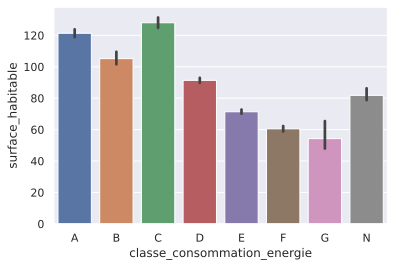

In [10]:
sns.barplot(x='classe_consommation_energie', y ='surface_habitable', data=results_pd)

Année de construction A

In [107]:
results_annee_construction = spark.sql("""
    SELECT
        classe_consommation_energie, annee_construction
    FROM ademe_33
    WHERE annee_construction < 2021
    AND annee_construction > 1900
    GROUP BY classe_consommation_energie, annee_construction
    ORDER BY classe_consommation_energie
""")
results_annee_construction.persist()

DataFrame[classe_consommation_energie: string, annee_construction: string]

In [108]:
results_annee_construction_pd = results_annee_construction.toPandas()
results_annee_construction_pd.annee_construction = pd.to_numeric(results_annee_construction_pd.annee_construction)

<AxesSubplot:xlabel='classe_consommation_energie', ylabel='annee_construction'>

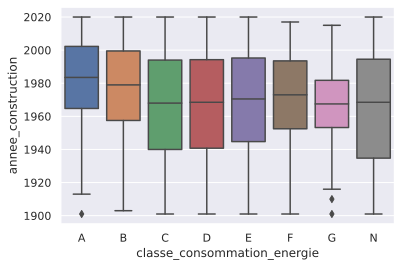

In [109]:
sns.boxplot(x='classe_consommation_energie', y ='annee_construction', data=results_annee_construction_pd)

A sont plus récents

% de logements A par ville

In [72]:
communeTotal = spark.sql("""
    SELECT
        commune, COUNT(*) as nb_logements
    FROM ademe_33
    GROUP BY commune
    ORDER BY nb_logements DESC
""")
communeTotal.persist()
communeTotal.createOrReplaceTempView("communeTotal")
communeTotal.show(10)

+-----------------+------------+
|          commune|nb_logements|
+-----------------+------------+
|         BORDEAUX|       64594|
|          TALENCE|        9900|
|           PESSAC|        9880|
|         MERIGNAC|        7583|
|VILLENAVE-D'ORNON|        6879|
|         MÉRIGNAC|        6213|
|         LIBOURNE|        4385|
|            CENON|        4353|
|         ARCACHON|        4338|
|       LE BOUSCAT|        4190|
+-----------------+------------+
only showing top 10 rows



In [73]:
a = spark.sql("""
    SELECT
        *
    FROM communeTotal
""")
a.show(10)

+-----------------+------------+
|          commune|nb_logements|
+-----------------+------------+
|         BORDEAUX|       64594|
|          TALENCE|        9900|
|           PESSAC|        9880|
|         MERIGNAC|        7583|
|VILLENAVE-D'ORNON|        6879|
|         MÉRIGNAC|        6213|
|         LIBOURNE|        4385|
|            CENON|        4353|
|         ARCACHON|        4338|
|       LE BOUSCAT|        4190|
+-----------------+------------+
only showing top 10 rows



In [77]:
communeMostA = spark.sql("""
    SELECT
        ademe_33.commune, (COUNT(ademe_33.id)/communeTotal.nb_logements) as taux_A, COUNT(ademe_33.id), communeTotal.nb_logements 
    FROM ademe_33 INNER JOIN communeTotal ON ademe_33.commune = communeTotal.commune
    WHERE ademe_33.classe_consommation_energie='A'
    AND communeTotal.nb_logements>500
    GROUP BY ademe_33.commune, communeTotal.nb_logements 
    ORDER BY taux_A DESC
""")
communeMostA.persist()
communeMostA.show()

+--------------------+-------------------+---------+------------+
|             commune|             taux_A|count(id)|nb_logements|
+--------------------+-------------------+---------+------------+
|SAINT-AUBIN-DE-MEDOC|         0.80859375|      414|         512|
|SAINT-ANDRE-DE-CU...| 0.6684491978609626|      375|         561|
|SAINT-MEDARD-EN-J...| 0.6533816425120773|      541|         828|
|  SAINT-JEAN-D'ILLAC| 0.5250236071765817|      556|        1059|
|             TRESSES| 0.5107794361525705|      308|         603|
|                IZON| 0.5024630541871922|      408|         812|
|         MARCHEPRIME|0.48291233283803864|      325|         673|
| MARTIGNAS-SUR-JALLE|0.47297297297297297|      385|         814|
|   VILLENAVE-D'ORNON| 0.4467219072539613|     3073|        6879|
|  ANDERNOS-LES-BAINS| 0.4416727806309611|      602|        1363|
|    LA TESTE-DE-BUCH| 0.4316505955757232|     1522|        3526|
|        CARBON-BLANC|0.42407199100112486|      377|         889|
|         

In [14]:
communeMostA_pd = communeMostA.toPandas()
communeMostA_pd = communeMostA_pd.truncate(0,5)

In [16]:
sns.barplot(x='commune', y ='nb_logements_A', data=communeMostA_pd)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'BORDEAUX'),
  Text(1, 0, "VILLENAVE-D'ORNON"),
  Text(2, 0, 'PESSAC'),
  Text(3, 0, 'MERIGNAC'),
  Text(4, 0, 'LA TESTE-DE-BUCH'),
  Text(5, 0, 'TALENCE')])

In [18]:
typeBattimentA = spark.sql("""
    SELECT
        tr002_type_batiment_libelle, COUNT(*) as nb_logements_A
    FROM ademe_33
    WHERE classe_consommation_energie='A'
    GROUP BY tr002_type_batiment_libelle
    ORDER BY nb_logements_A DESC
""")
typeBattimentA.persist()
typeBattimentA.show()

+---------------------------+--------------+
|tr002_type_batiment_libelle|nb_logements_A|
+---------------------------+--------------+
|                Appartement|         29764|
|                     Maison|         24533|
|       Logements collectifs|          2051|
+---------------------------+--------------+



In [19]:
typeBattiment = spark.sql("""
    SELECT
        tr002_type_batiment_libelle, COUNT(*) as nb_logements
    FROM ademe_33
    GROUP BY tr002_type_batiment_libelle
    ORDER BY nb_logements DESC
""")
typeBattiment.persist()
typeBattiment.show()

+---------------------------+------------+
|tr002_type_batiment_libelle|nb_logements|
+---------------------------+------------+
|                Appartement|      141149|
|                     Maison|      125824|
|       Logements collectifs|       13652|
+---------------------------+------------+



In [32]:
typeBattimentA_pd = typeBattimentA.toPandas()
typeBattiment_pd = typeBattiment.toPandas()

In [39]:
typeBattimentA_pd["nb_logements_A"]/typeBattiment_pd["nb_logements"]

0    0.210869
1    0.194979
2    0.150234
dtype: float64

In [ ]:
corr_results = results_pd.corr()
corr_resultsmostACommune

Estimation GES est l'attribut le plus corrélé à la consommation d'énergie

In [ ]:
sns.heatmap(corr_results, square=True, annot=True, fmt=".2f")